# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing as prep
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [76]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ';')

In [77]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [78]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [79]:
#azdias.info()

In [80]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [81]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ALTERSKATEGORIE_GROB,person,ordinal,[-1]
freq,1,43,49,26


In [82]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [83]:
# Identify missing or unknown data values and convert them to NaNs.

def transform_missing_or_unknown(input_str):
    output_list = []
    input_str = input_str.replace("[", '')
    input_str = input_str.replace("]", '')
    input_list = input_str.split(",")
    for ii in input_list:
        try:
            output_list.append(float(int(ii)))
        except ValueError:
            output_list.append(ii)
    #Return a list with missing or unknown values
    return output_list    

In [84]:
# A quick test
missing_test = feat_info.loc[0]['missing_or_unknown']

transform_missing_or_unknown(missing_test)

[-1.0, 0.0]

In [85]:
print(type(azdias.loc[0]['AGER_TYP']))

<class 'numpy.int64'>


In [86]:
# # Examining the data
# for ii in range(10):
#     print(azdias.loc[ii]['OST_WEST_KZ'])
    
# new_feat_info = feat_info.set_index('attribute')
# print(new_feat_info.loc['OST_WEST_KZ'])

# new_feat_info.head()
# feat_info.head()

In [87]:
print(feat_info.loc[12]['missing_or_unknown'])

[]


In [88]:
for ii in range(len(feat_info)):
    #print("row number: ",ii)
    missing_or_unknown_str = feat_info.loc[ii]['missing_or_unknown']
    missing_or_unknown_list = transform_missing_or_unknown(missing_or_unknown_str)
    azdias[feat_info.loc[ii]['attribute']] = [np.nan if element in missing_or_unknown_list else element for element in azdias[feat_info.loc[ii]['attribute']]]
    

In [89]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [90]:
#from collections import Counter
len(azdias)
azdias_count = azdias.count()
print(azdias_count[1])
label = azdias.columns.values
print(label[0])

888340
AGER_TYP


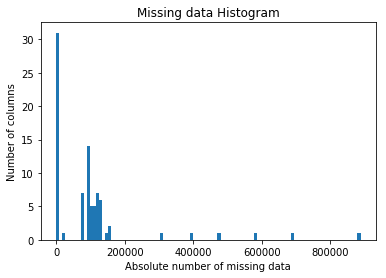

In [91]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_data_arr = len(azdias) - azdias.count()
plt.hist(missing_data_arr, bins = 100)
plt.ylabel('Number of columns')
plt.xlabel('Absolute number of missing data')
plt.title('Missing data Histogram')
plt.show()

In [92]:
# Investigate patterns in the amount of missing data in each column.

missing_data_arr_200k = missing_data_arr[missing_data_arr > 200000]
print(missing_data_arr_200k)

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64


In [93]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_drop = azdias.drop(missing_data_arr_200k.index, axis = 1)

azdias_drop.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The columns were removed from the dataset were:<br>
<br>
AGER_TYP        <br>
GEBURTSJAHR     <br>
TITEL_KZ        <br>
ALTER_HH        <br>
KK_KUNDENTYP    <br>
KBA05_BAUMAX    <br>

as they appear to have high number of missing values starting from circa 310000 out of 880000  at column ALTER_HH. <br>

A very interesting pattern is that number of missing values increase with a volume between 80-100k from 310k to 880k with a gap at 780k.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [257]:
# How much data is missing in each row of the dataset?
azdias_null_rows =  azdias_drop.isnull().sum(axis=1)
#print(azdias_null_rows)

<Container object of 20 artists>

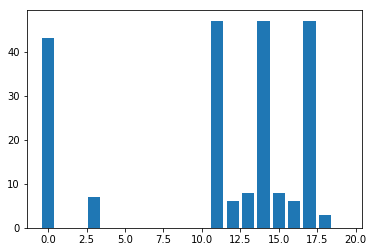

In [215]:
limit = 20
plt.bar(azdias_null_rows[:limit].index, azdias_null_rows[:limit])

<Container object of 200 artists>

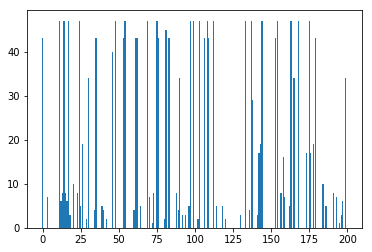

In [216]:
limit = 200
plt.bar(azdias_null_rows[:limit].index, azdias_null_rows[:limit])

In [219]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

'''
30 looks like a good separator for the rows in this dataset
'''
azdias_row_above = azdias_drop.loc[azdias_null_rows[azdias_null_rows > 20].index]
azdias_row_above.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [220]:
azdias_row_below = azdias_drop.loc[azdias_null_rows[azdias_null_rows <= 20].index]
azdias_row_below.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [221]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_dist(dataframe1_in, dataframe2_in, str_in):
    
    plt.subplot(1,2,1)
    
    distr1 = sns.countplot(dataframe1_in[str_in])
    
    #plt.plot(distr1)
    
    plt.subplot(1,2,2)
    
    distr2 = sns.countplot(dataframe2_in[str_in])
    
    #plt.plot(distr2)    

    plt.show()

In [222]:
print(azdias_row_below.columns.values[0])

print(type(azdias_row_below.index[0]))


ALTERSKATEGORIE_GROB
<class 'numpy.int64'>


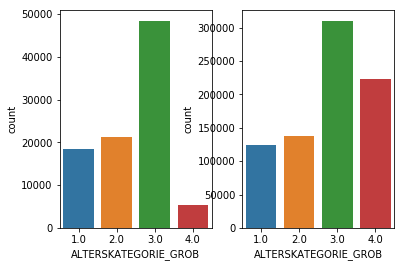

ALTERSKATEGORIE_GROB


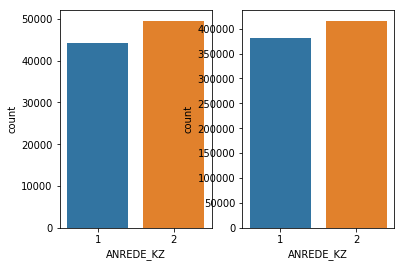

ANREDE_KZ


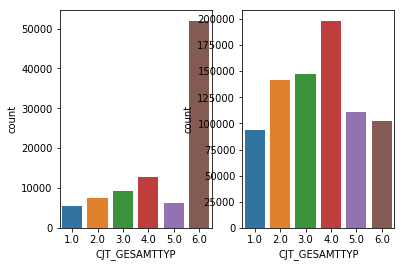

CJT_GESAMTTYP


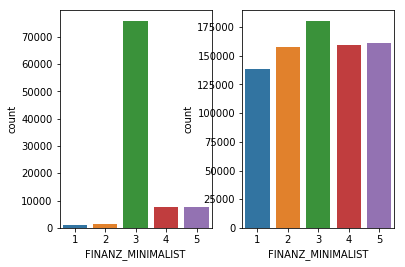

FINANZ_MINIMALIST


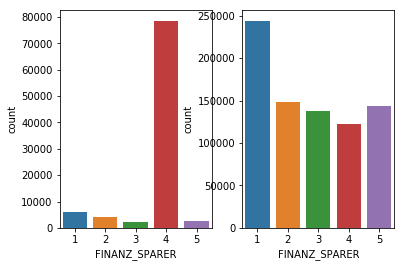

FINANZ_SPARER


In [223]:
for ii in range(5):
    compare_dist(azdias_row_above, azdias_row_below, azdias_drop.columns.values[ii])
    print(azdias_drop.columns.values[ii])

#### Discussion 1.1.3: Assess Missing Data in Each Row

Above we compare the distributions from the two new datasets that have defined previously for columns that don't have lots of missing data. So, we see that there are distributions with quite similar pattern like in columns ALTERSKATEGORIE_GROB and ANREDE_KZ but other ones can differ significatly.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [102]:
# How many features are there of each data type?
feat_info.info()

feat_info["type"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [103]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ALTERSKATEGORIE_GROB,person,ordinal,[-1]
freq,1,43,49,26


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [225]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info[feat_info["type"] == 'categorical']
cat_attribute = categorical.set_index('attribute')
binary_list = []
multi_var_list = []

for ii in cat_attribute.index:
    if ii in azdias_row_below.columns.values:
        print(ii)
        print(azdias_row_below[ii].unique())
        print("Number of variables: ", len(azdias_row_below[ii].unique()))
        print()
        if len(azdias_row_below[ii].unique()) > 2:
            multi_var_list.append(ii)
        else:
            binary_list.append(ii)
        
print("multi variable: ", multi_var_list)
print("binary: ", binary_list)

ANREDE_KZ
[2 1]
Number of variables:  2

CJT_GESAMTTYP
[  5.   3.   2.   4.   1.   6.  nan]
Number of variables:  7

FINANZTYP
[1 6 5 2 4 3]
Number of variables:  6

GFK_URLAUBERTYP
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
Number of variables:  13

GREEN_AVANTGARDE
[0 1]
Number of variables:  2

LP_FAMILIE_FEIN
[  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
Number of variables:  12

LP_FAMILIE_GROB
[  3.   1.  nan   5.   2.   4.]
Number of variables:  6

LP_STATUS_FEIN
[  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
Number of variables:  11

LP_STATUS_GROB
[  1.   2.   4.   5.   3.  nan]
Number of variables:  6

NATIONALITAET_KZ
[  1.   3.   2.  nan]
Number of variables:  4

SHOPPER_TYP
[  3.   2.   1.   0.  nan]
Number of variables:  5

SOHO_KZ
[ 1.  0.]
Number of variables:  2

VERS_TYP
[  2.   1.  nan]
Number of variables:  3

ZABEOTYP
[5 3 4 1 6 2]
Number of variables:  6

GEBAEUDETYP
[ 8.  1.  3.  2.  6.  4.  5.]
Number of variable

In [226]:
# Re-encode categorical variable(s) to be kept in the analysis.
dataset_ohe = azdias_row_below.drop('CAMEO_DEU_2015', axis = 1)
dataset_ohe.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ',
       'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO

In [227]:
print(type(multi_var_list))
print(type(multi_var_list[0]))
# for ii in multi_var_list:
#     dataset_ohe = pd.get_dummies(dataset_ohe, ii)
multi_var_list.remove('CAMEO_DEU_2015')
dataset_ohe = pd.get_dummies(dataset_ohe, columns = multi_var_list)

<class 'list'>
<class 'str'>


In [228]:
dataset_ohe.shape

(797426, 151)

In [229]:
dataset_ohe.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE',
       'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PK

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

The list with the variable that kept for the analysis is shown below:

'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015'

The CAMEO_DEU_2015 has been dropped as it seemed unnecessary to keep having way too many values, 45 in total.

The steps that have been followed were:

1. Create a list with categorical variables
2. Distiguish the binary from multivariables
3. Remove these from the multivariables that have many values and particularly more than 10
4. one hot encode these variables in a new dataframe

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [230]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
feat_info[feat_info["attribute"] == "PRAEGENDE_JUGENDJAHRE"]


,attribute,information_level,type,missing_or_unknown
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"


In [231]:
'''
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)'''

"\nDominating movement of person's youth (avantgarde vs. mainstream; east vs. west)\n- -1: unknown\n-  0: unknown\n-  1: 40s - war years (Mainstream, E+W)\n-  2: 40s - reconstruction years (Avantgarde, E+W)\n-  3: 50s - economic miracle (Mainstream, E+W)\n-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)\n-  5: 60s - economic miracle (Mainstream, E+W)\n-  6: 60s - generation 68 / student protestors (Avantgarde, W)\n-  7: 60s - opponents to the building of the Wall (Avantgarde, E)\n-  8: 70s - family orientation (Mainstream, E+W)\n-  9: 70s - peace movement (Avantgarde, E+W)\n- 10: 80s - Generation Golf (Mainstream, W)\n- 11: 80s - ecological awareness (Avantgarde, W)\n- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)\n- 13: 80s - Swords into ploughshares (Avantgarde, E)\n- 14: 90s - digital media kids (Mainstream, E+W)\n- 15: 90s - ecological awareness (Avantgarde, E+W)"

In [232]:
#azdias.loc[0]['PRAEGENDE_JUGENDJAHRE']

In [233]:
def decade_var(value):
    if value in (1, 2):
        value = 0
    elif value in (3, 4):
        value = 1
    elif value in (5, 6, 7):
        value = 2
    elif value in (8, 9):
        value = 3
    elif value in (10, 11, 12, 13):
        value = 4
    elif value in (14, 15):
        value = 5
    else:
        value = np.nan
    return value
            
def movement_var(value):
    if value in (1, 3, 5, 8, 10, 12, 14):
        value = 0
    elif value in (2, 4, 6, 7, 9, 11, 13, 15):
        value = 1
    else:
        value = np.nan    
    return value

In [234]:
dataset_ohe['PRAEGENDE_JUGENDJAHRE_DECADE'] = dataset_ohe['PRAEGENDE_JUGENDJAHRE'].apply(decade_var)

In [235]:
dataset_ohe['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = dataset_ohe['PRAEGENDE_JUGENDJAHRE'].apply(movement_var)

In [236]:
dataset_ohe = dataset_ohe.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)

In [237]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

'''German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown'''

'German CAMEO: Wealth / Life Stage Typology, mapped to international code\n- -1: unknown\n- 11: Wealthy Households - Pre-Family Couples & Singles\n- 12: Wealthy Households - Young Couples With Children\n- 13: Wealthy Households - Families With School Age Children\n- 14: Wealthy Households - Older Families &  Mature Couples\n- 15: Wealthy Households - Elders In Retirement\n- 21: Prosperous Households - Pre-Family Couples & Singles\n- 22: Prosperous Households - Young Couples With Children\n- 23: Prosperous Households - Families With School Age Children\n- 24: Prosperous Households - Older Families & Mature Couples\n- 25: Prosperous Households - Elders In Retirement\n- 31: Comfortable Households - Pre-Family Couples & Singles\n- 32: Comfortable Households - Young Couples With Children\n- 33: Comfortable Households - Families With School Age Children\n- 34: Comfortable Households - Older Families & Mature Couples\n- 35: Comfortable Households - Elders In Retirement\n- 41: Less Affluent Ho

In [238]:
def tens(value):
    if value in ('11', '12', '13', '14', '15'):
        value = 1
    elif value in ('21', '22', '23', '24', '25'):
        value = 2
    elif value in ('31', '32', '33', '34', '35'):
        value = 3
    elif value in ('41', '42', '43', '44', '45'):
        value = 4
    elif value in ('51', '52', '53', '54', '55'):
        value = 5
    else:
        value = np.nan
    return value
            
def ones(value):
    if value in ('11', '21', '31', '41', '51'):
        value = 1
    elif value in ('12', '22', '32', '34', '35'):
        value = 2
    elif value in ('13', '23', '33', '43', '53'):
        value = 3
    elif value in ('14', '24', '34', '44', '54'):
        value = 4
    elif value in ('15', '25', '35', '45', '55'):
        value = 5
    else:
        value = np.nan
    return value

In [239]:
#dataset_ohe.columns.values

In [240]:
#azdias.columns.values

In [241]:
dataset_ohe['CAMEO_INTL_2015_TENS'] = dataset_ohe['CAMEO_INTL_2015'].apply(tens)
dataset_ohe['CAMEO_INTL_2015_ONES'] = dataset_ohe['CAMEO_INTL_2015'].apply(ones)
dataset_ohe = dataset_ohe.drop('CAMEO_INTL_2015', axis = 1)

In [242]:
feat_mixed = feat_info[feat_info['type'] == 'mixed']

for ii in feat_mixed['attribute']:
    try :
        dataset_ohe = dataset_ohe.drop(ii, axis = 1)
    except:
        print(ii, " already removed" )

PRAEGENDE_JUGENDJAHRE  already removed
CAMEO_INTL_2015  already removed
KBA05_BAUMAX  already removed


In [243]:
dataset_ohe.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,5.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,5.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,3.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,3.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,1.0,0.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

The recommended mixed variables CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE have been kept and encoded appropriately.

The steps followed were:
1. Create a function that modifies each element of the column according to the desired encoding
2. Apply all relevant functions to the dataframe and set the new values to a new column
3. Drop the old column

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [245]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

'''We first check the column names to see if something that shouldn't have been included is still in our dataset'''

"We first check the column names to see if something that shouldn't have been included is still in our dataset"

In [246]:
dataset_ohe.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ',
       'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_

In [249]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
print(dataset_ohe.shape)
dataset_ohe.head()


(797426, 149)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,5.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,5.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,3.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,3.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,1.0,0.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [2]:
# At this cell we define all necessary functions in order not to rerun the whole note if we need to lean the data
def transform_missing_or_unknown(input_str):
    output_list = []
    input_str = input_str.replace("[", '')
    input_str = input_str.replace("]", '')
    input_list = input_str.split(",")
    for ii in input_list:
        try:
            output_list.append(float(int(ii)))
        except ValueError:
            output_list.append(ii)
    #Return a list with missing or unknown values
    return output_list  

def decade_var(value):
    if value in (1, 2):
        value = 0
    elif value in (3, 4):
        value = 1
    elif value in (5, 6, 7):
        value = 2
    elif value in (8, 9):
        value = 3
    elif value in (10, 11, 12, 13):
        value = 4
    elif value in (14, 15):
        value = 5
    else:
        value = np.nan
    return value
            
def movement_var(value):
    if value in (1, 3, 5, 8, 10, 12, 14):
        value = 0
    elif value in (2, 4, 6, 7, 9, 11, 13, 15):
        value = 1
    else:
        value = np.nan    
    return value

def tens(value):
    if value in ('11', '12', '13', '14', '15'):
        value = 1
    elif value in ('21', '22', '23', '24', '25'):
        value = 2
    elif value in ('31', '32', '33', '34', '35'):
        value = 3
    elif value in ('41', '42', '43', '44', '45'):
        value = 4
    elif value in ('51', '52', '53', '54', '55'):
        value = 5
    else:
        value = np.nan
    return value
            
def ones(value):
    if value in ('11', '21', '31', '41', '51'):
        value = 1
    elif value in ('12', '22', '32', '34', '35'):
        value = 2
    elif value in ('13', '23', '33', '43', '53'):
        value = 3
    elif value in ('14', '24', '34', '44', '54'):
        value = 4
    elif value in ('15', '25', '35', '45', '55'):
        value = 5
    else:
        value = np.nan
    return value

In [3]:
def clean_data(df, percentage):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ';')
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for ii in range(len(feat_info)):
    #print("row number: ",ii)
        missing_or_unknown_str = feat_info.loc[ii]['missing_or_unknown']
        missing_or_unknown_list = transform_missing_or_unknown(missing_or_unknown_str)
        df[feat_info.loc[ii]['attribute']] = [np.nan if element in missing_or_unknown_list else element for element in df[feat_info.loc[ii]['attribute']]]

    # remove selected columns and rows, ...

    missing_data_arr = len(df) - df.count()

    missing_data_arr_200k = missing_data_arr[missing_data_arr > 400000]

    azdias_drop = df.drop(missing_data_arr_200k.index, axis = 1)
    
    azdias_null_rows =  azdias_drop.isnull().sum(axis=1)

    azdias_row_below = azdias_drop.loc[azdias_null_rows[azdias_null_rows <= percentage].index]

    categorical = feat_info[feat_info["type"] == 'categorical']
    cat_attribute = categorical.set_index('attribute')
    binary_list = []
    multi_var_list = []

    for ii in cat_attribute.index:
        if ii in azdias_row_below.columns.values:
            #print(ii)
            print(azdias_row_below[ii].unique())
            #print("Number of variables: ", len(azdias_row_below[ii].unique()))
            #print()
            if len(azdias_row_below[ii].unique()) > 2:
                multi_var_list.append(ii)
            else:
                binary_list.append(ii)
    
    # select, re-encode, and engineer column values.
    try:
        dataset_ohe = azdias_row_below.drop('CAMEO_DEU_2015', axis = 1)
        #dataset_ohe.columns.values

        multi_var_list.remove('CAMEO_DEU_2015')
    except:
        dataset_ohe = azdias_row_below 
        print('CAMEO_DEU_2015 not found.')
        
    dataset_ohe = pd.get_dummies(dataset_ohe, columns = multi_var_list)



    dataset_ohe['PRAEGENDE_JUGENDJAHRE_DECADE'] = dataset_ohe['PRAEGENDE_JUGENDJAHRE'].apply(decade_var)

    dataset_ohe['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = dataset_ohe['PRAEGENDE_JUGENDJAHRE'].apply(movement_var)

    dataset_ohe = dataset_ohe.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)



    dataset_ohe['CAMEO_INTL_2015_TENS'] = dataset_ohe['CAMEO_INTL_2015'].apply(tens)
    dataset_ohe['CAMEO_INTL_2015_ONES'] = dataset_ohe['CAMEO_INTL_2015'].apply(ones)
    dataset_ohe = dataset_ohe.drop('CAMEO_INTL_2015', axis = 1)

    feat_mixed = feat_info[feat_info['type'] == 'mixed']

    for ii in feat_mixed['attribute']:
        try :
            dataset_ohe = dataset_ohe.drop(ii, axis = 1)
        except:
            print(ii, " already removed" )

    
    # Return the cleaned dataframe.
    
    return dataset_ohe

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [4]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_2 = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ';')
dataset_ohe_drop = clean_data(azdias_2, 20)
dataset_ohe_null_rows = dataset_ohe_drop.isnull().sum(axis=1)
#dataset_ohe_drop = dataset_ohe_drop.loc[dataset_ohe_null_rows[dataset_ohe_null_rows == 0].index]

[2 1]
[  5.   3.   2.   4.   1.   6.  nan]
[1 6 5 2 4 3]
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.  nan]
[0 1]
[  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
[  3.   1.  nan   5.   2.   4.]
[  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
[  1.   2.   4.   5.   3.  nan]
[  1.   3.   2.  nan]
[  3.   2.   1.   0.  nan]
[ 1.  0.]
[  2.   1.  nan]
[5 3 4 1 6 2]
[ 8.  1.  3.  2.  6.  4.  5.]
['W' 'O']
['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']
PRAEGENDE_JUGENDJAHRE  already removed
CAMEO_INTL_2015  already removed
KBA05_BAUMAX  already removed


In [5]:
dataset_ohe_drop.loc[dataset_ohe_drop['OST_WEST_KZ']=='W','OST_WEST_KZ']=0
dataset_ohe_drop.loc[dataset_ohe_drop['OST_WEST_KZ']=='O','OST_WEST_KZ']=1

In [6]:
dataset_ohe_drop.isnull().sum().sum()

1267954

In [7]:
print(len(dataset_ohe_drop))
dataset_ohe_drop.shape

796960


(796960, 151)

In [8]:
customers_prep = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')
customers_updated_prep = clean_data(customers_prep, 20)

[  2.  nan   1.   3.]
[1 2]
[  5.   2.   6.   4.   1.   3.  nan]
[2 6 5 3 1 4]
[  4.   3.  10.   2.  11.   8.   1.   5.   9.  12.   7.   6.  nan]
[1 0]
[  2.   1.  nan  10.   8.   6.  11.   9.   7.   5.   3.   4.]
[  2.   1.  nan   5.   4.   3.]
[ 10.   9.   1.   7.   6.   3.   8.   5.   4.   2.  nan]
[  5.   4.   1.   3.   2.  nan]
[  1.   2.  nan   3.]
[  3.   1.   0.   2.  nan]
[ 0.  1.]
[ nan   1.   4.   3.   5.]
[  1.   2.  nan]
[3 1 2 4 6 5]
[ nan   2.   5.   4.   1.   3.   6.]
[ 1.  8.  2.  3.  4.  6.]
['W' 'O']
['1' '5' '4' '7' '3' '9' '2' '6' '8' nan]
['1A' '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C' '4E'
 '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C' '5A' '2B'
 '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D' '6F' '4D' nan]
PRAEGENDE_JUGENDJAHRE  already removed
CAMEO_INTL_2015  already removed


In [9]:
missing_columns = []
for ii in customers_updated_prep.columns.values:
    if ii in dataset_ohe_drop.columns.values:
        pass
    else:
        missing_columns.append(ii)
for ii in dataset_ohe_drop.columns.values:
    if ii in customers_updated_prep.columns.values:
        pass
    else:
        missing_columns.append(ii)

In [10]:
for ii in missing_columns:
    try:
        dataset_ohe_drop = dataset_ohe_drop.drop(ii, axis = 1)
    except:
        print(ii , "not in dataset_ohe_drop")
        
    try:
        customers_updated_prep = customers_updated_prep.drop(ii, axis = 1)
    except:
        print(ii , "not in customers_updated")   

AGER_TYP_1.0 not in dataset_ohe_drop
AGER_TYP_2.0 not in dataset_ohe_drop
AGER_TYP_3.0 not in dataset_ohe_drop
TITEL_KZ_1.0 not in dataset_ohe_drop
TITEL_KZ_3.0 not in dataset_ohe_drop
TITEL_KZ_4.0 not in dataset_ohe_drop
TITEL_KZ_5.0 not in dataset_ohe_drop
KK_KUNDENTYP_1.0 not in dataset_ohe_drop
KK_KUNDENTYP_2.0 not in dataset_ohe_drop
KK_KUNDENTYP_3.0 not in dataset_ohe_drop
KK_KUNDENTYP_4.0 not in dataset_ohe_drop
KK_KUNDENTYP_5.0 not in dataset_ohe_drop
KK_KUNDENTYP_6.0 not in dataset_ohe_drop
GEBAEUDETYP_5.0 not in customers_updated


In [11]:
imp= Imputer(missing_values='NaN', strategy='most_frequent')
azdias_encode_imputed= pd.DataFrame(data=imp.fit_transform(dataset_ohe_drop),index=dataset_ohe_drop.index, columns=dataset_ohe_drop.columns)

In [12]:
# Apply feature scaling to the general population demographics data.
standard_scaler = prep.StandardScaler()
data_standard_scaler = standard_scaler.fit_transform(azdias_encode_imputed)

In [13]:
data_standard_scaler.shape

(796960, 150)

In [14]:
customers_updated_prep.shape

(141178, 150)

### Discussion 2.1: Apply Feature Scaling

I initially checked the number of NaN remained in the reduced dataset and the removed any row had any. Although, this seems to be a blunt way to handle it the number of the remaining data is still massive and it has been assessed that it's worth going ahead with this way instead of dealing with more complicated solution. Additionally, we can always come back and assess this decision if any we realise that data is not sufficient. 
Also, the data has been further processed in column OST_WEST_KZ to replace variables of type string with integers as it has missed from the previous steps.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [15]:
len(azdias_encode_imputed.columns)

150

In [16]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(data_standard_scaler)

In [17]:
def scree_plot(pca, num_display):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind[:num_display], vals[:num_display])
    ax.plot(ind[:num_display], cumvals[:num_display])
    for i in range(num_display):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

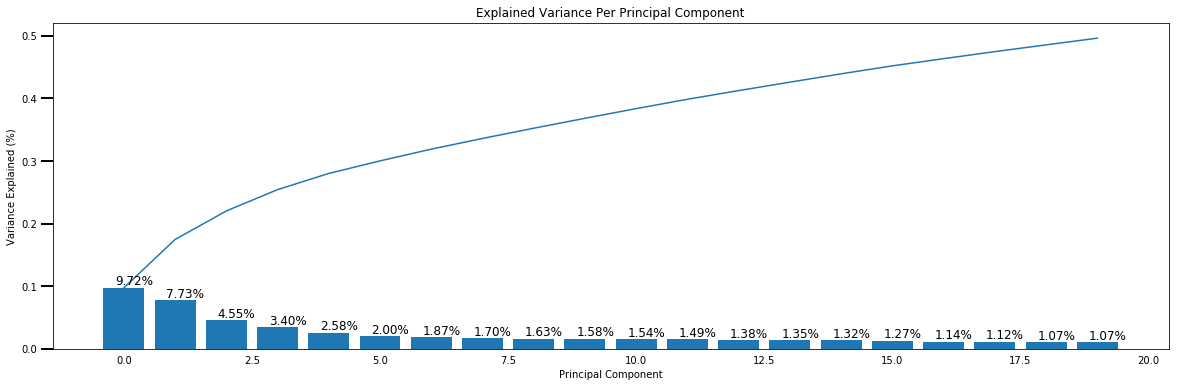

In [18]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca, 20)

In [19]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(20)
X_pca = pca.fit_transform(data_standard_scaler)

### Discussion 2.2: Perform Dimensionality Reduction

The graph above illustrates the variance explained by each component. It becomes quite clear that variance the drops quite fast and tends asymptotically to a very small value 0 - 1.0 after the first 7 component more or less. This means that after this the components contributed significantly less than the first ones and therefore can be drop from our analysis as this move will have limited impact in the final result. The line was drawn in 1% so I picked the first 20 components but we could have safely selected a number smaller than that around 15 for example.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [20]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_results(full_dataset, pca, dim):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    components = pd.concat([components.head(dim)])
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    #Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        if i < dim:
            ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))
        else:
            break

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



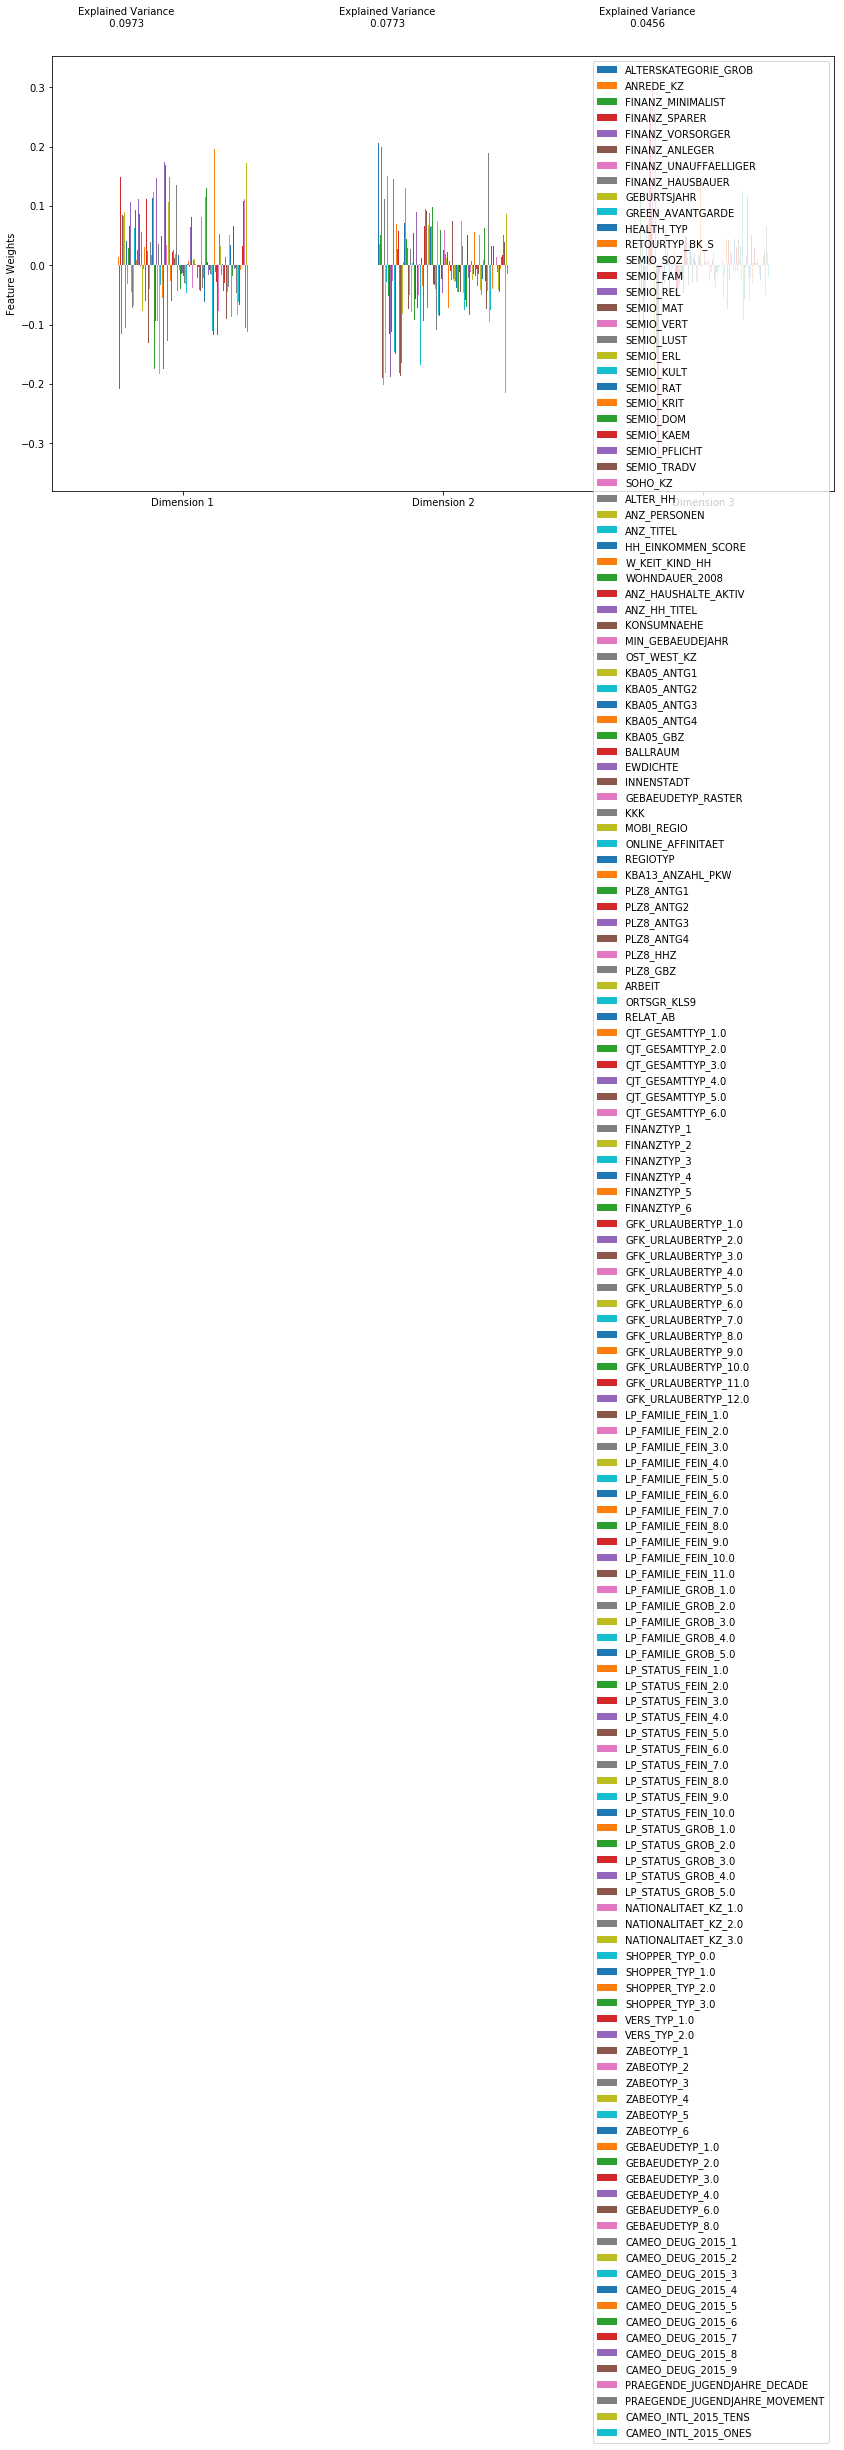

In [21]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_dataframe = pca_results(azdias_encode_imputed, pca, 3)

In [22]:
# Sort feature weights for first component
feature_weights = pd.DataFrame(pca.components_, columns = azdias_encode_imputed.columns.values)
feature_weights.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
0,-0.115997,0.013844,-0.208125,0.148666,-0.115563,0.085446,0.083795,0.139630,0.090133,-0.105073,...,-0.066818,-0.007643,0.000882,0.032283,0.085346,0.109151,0.112707,-0.105073,0.173115,-0.113068
1,0.207038,0.036244,0.051975,-0.201082,0.198916,-0.190137,-0.200874,0.111673,-0.180828,-0.027845,...,-0.045092,-0.006899,0.013459,0.016766,0.051478,0.039136,-0.214635,-0.027845,0.087079,-0.014779
2,0.005917,-0.347033,0.121587,-0.047571,0.040131,-0.145590,-0.041246,-0.057688,-0.039614,0.066087,...,-0.024659,0.000310,-0.004906,0.000581,0.013527,0.023698,-0.049895,0.066087,0.022225,-0.019799
3,-0.013584,0.073962,0.006586,0.001881,-0.005957,-0.070415,0.044634,-0.026635,0.021710,0.295636,...,-0.038804,0.014468,-0.026352,-0.012499,-0.003463,-0.002270,0.020934,0.295636,-0.047620,0.013694
4,0.053654,-0.033959,0.045136,-0.029475,0.031775,0.026566,-0.102477,-0.034974,-0.013323,-0.163267,...,-0.000741,-0.025735,0.004220,0.002251,0.046385,0.059586,-0.018951,-0.163267,0.098888,-0.050429


LP_STATUS_GROB_1.0      0.196068
HH_EINKOMMEN_SCORE      0.181265
PLZ8_ANTG3              0.174295
CAMEO_INTL_2015_TENS    0.173115
PLZ8_ANTG4              0.168358
ORTSGR_KLS9             0.149009
FINANZ_SPARER           0.148666
EWDICHTE                0.147339
FINANZ_HAUSBAUER        0.139630
FINANZTYP_1             0.134950
LP_STATUS_FEIN_10.0    -0.117499
LP_STATUS_GROB_5.0     -0.117499
INNENSTADT             -0.123041
PLZ8_GBZ               -0.126970
KONSUMNAEHE            -0.131191
PLZ8_ANTG1             -0.175178
KBA05_GBZ              -0.175280
KBA05_ANTG1            -0.175959
MOBI_REGIO             -0.183123
FINANZ_MINIMALIST      -0.208125
Name: 0, dtype: float64


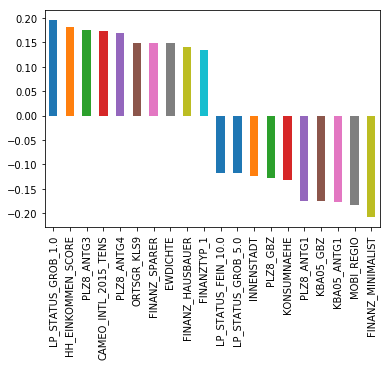

****************************************
ALTERSKATEGORIE_GROB            0.207038
FINANZ_VORSORGER                0.198916
ZABEOTYP_3                      0.189169
SEMIO_ERL                       0.160731
RETOURTYP_BK_S                  0.150667
SEMIO_LUST                      0.146164
W_KEIT_KIND_HH                  0.130487
LP_STATUS_FEIN_1.0              0.117556
FINANZ_HAUSBAUER                0.111673
FINANZTYP_5                     0.097880
ALTER_HH                       -0.164416
ONLINE_AFFINITAET              -0.167358
SEMIO_PFLICHT                  -0.180647
GEBURTSJAHR                    -0.180828
SEMIO_TRADV                    -0.186585
SEMIO_REL                      -0.188674
FINANZ_ANLEGER                 -0.190137
FINANZ_UNAUFFAELLIGER          -0.200874
FINANZ_SPARER                  -0.201082
PRAEGENDE_JUGENDJAHRE_DECADE   -0.214635
Name: 1, dtype: float64


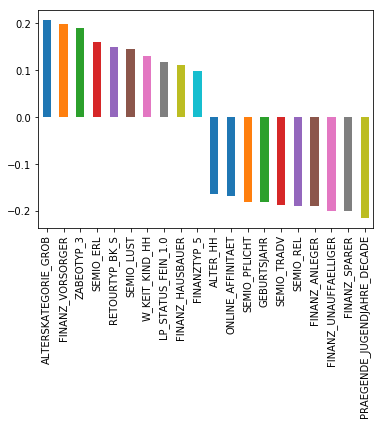

****************************************
SEMIO_VERT            0.319373
SEMIO_FAM             0.267081
SEMIO_SOZ             0.259921
SEMIO_KULT            0.259179
FINANZTYP_5           0.131401
SHOPPER_TYP_0.0       0.125129
SEMIO_REL             0.122669
FINANZ_MINIMALIST     0.121587
ZABEOTYP_1            0.114379
SEMIO_MAT             0.094937
LP_STATUS_FEIN_2.0   -0.073847
SHOPPER_TYP_2.0      -0.092442
FINANZTYP_1          -0.094180
FINANZ_ANLEGER       -0.145590
SEMIO_RAT            -0.147792
SEMIO_ERL            -0.215441
SEMIO_KRIT           -0.269157
SEMIO_DOM            -0.285926
SEMIO_KAEM           -0.317730
ANREDE_KZ            -0.347033
Name: 2, dtype: float64


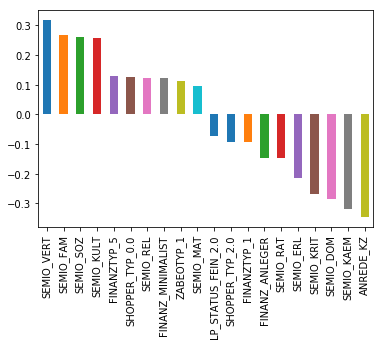

****************************************


In [23]:
for ii in range(3) :
    feature_weights_row = feature_weights.iloc[ii].sort_values(ascending = False)
    feature_weights_row = pd.concat([feature_weights_row.head(10), feature_weights_row.tail(10)])
    print(feature_weights_row)
    feature_weights_row.plot(kind='bar')
    ax = plt.gca()
    plt.show()
    print('''****************************************''')


In [24]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

### Discussion 2.3: Interpret Principal Components

It's really difficult to derive meaningful information because of the extent of the data.

However, having a closer look at each component separately we can obseve a few more things. So,

PCA 1:
The strongest positive effect at this componenent comes from LP_STATUS_GROB (family - single), HH_EINKOMMEN_SCORE (estimated household net income) and PLZ8_ANTG3 (number of 6- 10 houses in a specific area). Additionally, the strogest negative effect comes from FINAZ_MINIMALIST (finacial topology), MOVI_REGIO (movement patterns) and KBA05_ (number of family houses). It seems that PCA1 is significantly related with family charcteristics and their financial status.

PCA2:
The strongest positive effect at this componenent comes from ALTERSKATEGORIE_GROB (estimated age based on a given income analysis), FINANZ_VORSORGER (finacial topology) and ZABEOTYP_3 (energy consumption topology). Additionally, the strogest negative effect comes from multiple FINAZ_ weights (finacial topology) and PRAEGENDE_JUGENDJAHRE_DECADE (dominating movement of person's youth). So, in contrast to the previous one, in PCA2 age seems to play a important role instead of family. Of course, again financial topology is very important factor.

PCA3:
The strongest positive effect at this componenent comes from multiple SEMIO_ weights (personality topology) while the strogest negative effect comes from multiple SEMIO_ weights (personality topology) and ANDREDE_KZ (Gender). So, in contrast to the previous ones, in PCA3 personality and gender are the predominant factors affecting this component.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [25]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [26]:
# Over a number of different cluster counts..
scores_arr = []
length = len(X_pca)
for ii in range(10, 30, 3):

    # run k-means clustering on the data and...
    scores_arr.append(get_kmeans_score(X_pca, ii)/length)
    print(scores_arr)
    # compute the average within-cluster distances.   

[43.167302293485818]
[43.167302293485818, 40.165977655064189, 38.371054502086238]
[43.167302293485818, 40.165977655064189, 38.371054502086238, 36.941504349000525]
[43.167302293485818, 40.165977655064189, 38.371054502086238, 36.941504349000525, 35.49249816921143]
[43.167302293485818, 40.165977655064189, 38.371054502086238, 36.941504349000525, 35.49249816921143, 34.489328010734162]
[43.167302293485818, 40.165977655064189, 38.371054502086238, 36.941504349000525, 35.49249816921143, 34.489328010734162, 33.458699978181656]


In [27]:
np.save('scores_arr.npy',scores_arr)

CHECKPOINT !!!
LOAD NUMPY ARRAY scores_arr if necessary

In [28]:
scores_arr = np.load('scores_arr.npy')
scores_arr_load = np.load('scores_arr.npy')
print(scores_arr_load)

[ 43.16730229  40.16597766  38.3710545   36.94150435  35.49249817
  34.48932801  33.45869998]


Text(0.5,1,'Average Distance - Number of Centers')

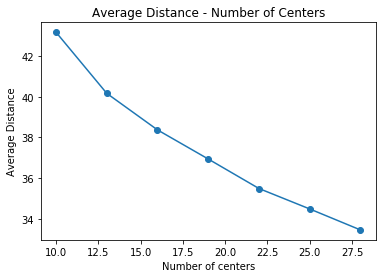

In [30]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
x = range(10, 30, 3)
y = scores_arr
plt.plot(x, y, marker = 'o')
plt.xlabel('Number of centers')
plt.ylabel('Average Distance')
plt.title('Average Distance - Number of Centers')

In [31]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 20)
kmeans_model = kmeans.fit(X_pca)
predictions = kmeans_model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

As per instructions, various numbers of k-means clusters have been investigated based on data derived from PCA analysis adn assessed based on the average distance. The most suitable number, more specifically 20, has been selected based on the graph illustrated above where at this point the rate of change of average distance drops less quickly than in the previous number centers. Then, the model was trained on the PCA data again and new predictions were taken.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [32]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')
customers.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,1,3,1,4.0,5,1,5,1,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0
7,1,4,1,2.0,5,1,5,1,2,2,...,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0
8,2,4,2,1.0,2,2,5,1,1,5,...,1.0,4.0,2.0,1.0,5.0,5.0,4.0,3.0,8.0,3.0
9,1,3,1,3.0,5,2,4,1,3,1,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0


In [33]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_updated = clean_data(customers, 20)

[  2.  nan   1.   3.]
[1 2]
[  5.   2.   6.   4.   1.   3.  nan]
[2 6 5 3 1 4]
[  4.   3.  10.   2.  11.   8.   1.   5.   9.  12.   7.   6.  nan]
[1 0]
[  2.   1.  nan  10.   8.   6.  11.   9.   7.   5.   3.   4.]
[  2.   1.  nan   5.   4.   3.]
[ 10.   9.   1.   7.   6.   3.   8.   5.   4.   2.  nan]
[  5.   4.   1.   3.   2.  nan]
[  1.   2.  nan   3.]
[  3.   1.   0.   2.  nan]
[ 0.  1.]
[ nan   1.   4.   3.   5.]
[  1.   2.  nan]
[3 1 2 4 6 5]
[ nan   2.   5.   4.   1.   3.   6.]
[ 1.  8.  2.  3.  4.  6.]
['W' 'O']
['1' '5' '4' '7' '3' '9' '2' '6' '8' nan]
['1A' '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C' '4E'
 '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C' '5A' '2B'
 '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D' '6F' '4D' nan]
PRAEGENDE_JUGENDJAHRE  already removed
CAMEO_INTL_2015  already removed


In [34]:
customers_updated_null = customers_updated.isnull().sum(axis=1)

In [35]:
customers_updated.isnull().sum().sum()
customers_updated.shape

(141178, 163)

In [36]:
customers_updated.loc[customers_updated['OST_WEST_KZ']=='W','OST_WEST_KZ']=0
customers_updated.loc[customers_updated['OST_WEST_KZ']=='O','OST_WEST_KZ']=1

In [37]:
for ii in missing_columns:
    try:
        customers_updated = customers_updated.drop(ii, axis = 1)
    except:
        print(ii , "not in customers_updated")

GEBAEUDETYP_5.0 not in customers_updated


In [38]:
imp= Imputer(missing_values='NaN', strategy='most_frequent')
customers_imputed= pd.DataFrame(data=imp.fit_transform(customers_updated),index=customers_updated.index, columns=customers_updated.columns)

In [39]:
customers_scaler = standard_scaler.fit_transform(customers_imputed)

In [40]:
customers_updated_pca = pca.transform(customers_scaler)

In [101]:
customers_predictions = kmeans_model.predict(customers_updated_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

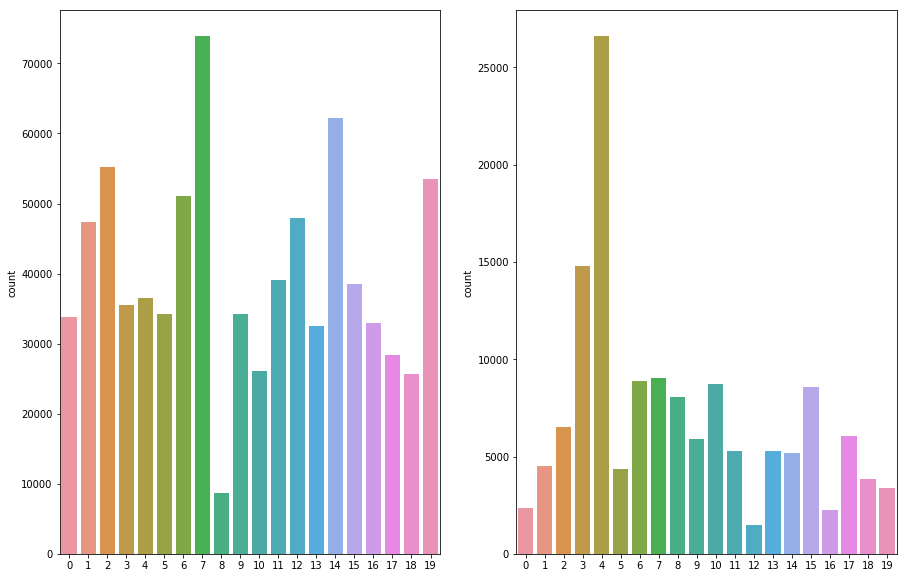

In [102]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,10))
plt.subplot(1,2,1)
distr1 = sns.countplot(predictions)

#plt.plot(distr1)
axs[0].set_title('General predictions')
plt.subplot(1,2,2)

distr2 = sns.countplot(customers_predictions)
axs[1].set_title('Customer predictions')
#plt.plot(distr2)

plt.show()

In [103]:
from collections import Counter

In [104]:
count_pred = Counter(predictions)
#count_pred_scaled = count_pred/len(predictions)

In [105]:
cnt_pred_list = [int(element) for ii, element in count_pred.items()]
cnt_pred_list_scl = [ii/len(predictions) for ii in cnt_pred_list]

In [106]:
count_customer_pred = Counter(customers_predictions)
cnt_customer_pred_list = [int(element) for ii, element in count_customer_pred.items()]
cnt_cust_pred_list_scl = [ii/len(customers_predictions) for ii in cnt_customer_pred_list]

In [107]:
diff_list = []                                    
for ii in range(len(cnt_pred_list_scl)):
    diff_list.append(cnt_cust_pred_list_scl[ii] - cnt_pred_list_scl[ii])

In [108]:
x_axis = range(len(cnt_cust_pred_list_scl))

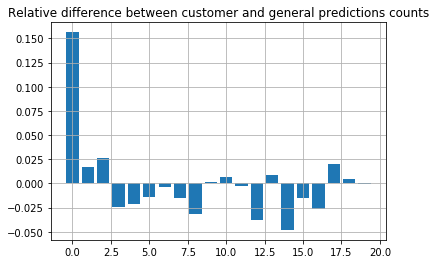

In [109]:
plt.bar(x_axis, diff_list)
plt.title('Relative difference between customer and general predictions counts')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [125]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_specs = pd.DataFrame(standard_scaler.inverse_transform(pca.inverse_transform(kmeans_model.cluster_centers_)), columns=azdias_encode_imputed.columns)
cluster_specs

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
0,2.995875,1.400286,3.401264,2.171534,4.097994,2.348064,2.461294,2.957126,1958.082335,0.356306,...,0.113220,0.096958,0.168971,0.086848,0.162604,0.077842,3.090656,0.364546,3.219229,2.810492
1,2.777451,1.768675,3.328726,2.248561,3.845505,2.800719,2.860096,3.046595,1956.889364,0.463457,...,0.263548,0.088590,0.149149,0.067338,0.009581,-0.024868,3.133955,0.471690,1.930916,3.604894
2,4.080399,1.579131,3.784630,0.946340,5.087122,0.992665,1.015571,4.068723,1939.362871,0.255143,...,0.022343,0.056336,0.066391,0.085915,0.178169,0.202950,0.961027,0.263390,3.599952,2.909398
3,3.851693,0.942390,5.512413,0.786708,5.126324,1.084790,1.224278,1.793040,1939.751265,0.209654,...,0.268010,0.085592,0.156257,0.025546,-0.005926,-0.032790,0.968025,0.217904,1.773253,3.851422
4,3.750362,0.887375,5.523171,0.926771,4.956732,0.782980,1.610440,1.553981,1941.948034,1.453316,...,0.206142,0.054598,0.075971,0.013557,-0.016033,-0.012755,1.244970,1.461483,1.371293,3.902869
5,2.734623,1.774216,2.766254,2.434213,3.751800,2.625954,2.716056,3.821794,1956.194632,0.252526,...,0.038714,0.057051,0.128436,0.096172,0.191657,0.153782,3.143674,0.260773,3.573487,2.610687
6,3.737922,1.135853,4.460608,0.932203,4.953177,0.537110,1.638679,3.192390,1942.129277,0.756737,...,0.076049,0.174643,0.178983,0.107712,0.116660,-0.010393,1.172165,0.764950,2.628493,3.382461
7,3.914505,1.725578,5.114686,0.863417,4.984283,1.135389,1.568904,1.927935,1940.963121,1.407337,...,0.208427,0.059131,0.071194,0.018627,-0.023731,-0.025820,1.193420,1.415507,1.283712,4.010200
8,3.089094,1.195713,4.960243,1.769635,3.881646,2.029552,2.559040,0.829422,1953.416460,0.311318,...,0.238929,0.121468,0.068044,0.062731,-0.027423,-0.013717,2.810648,0.319562,1.754956,3.357410
9,3.745430,1.203172,4.861065,1.290401,4.530425,1.592451,1.733399,1.903726,1945.876135,0.717342,...,0.310853,0.095035,0.087967,0.069218,0.051163,-0.022134,1.870730,0.725558,1.934973,3.299051


In [129]:
cluster_specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 150 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_ONES
dtypes: float64(150)
memory usage: 23.5 KB


In [141]:
feature_weights = pd.DataFrame(pca.components_, columns = azdias_encode_imputed.columns.values)
feature_weights.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_TENS,CAMEO_INTL_2015_ONES
0,-0.115997,0.013844,-0.208125,0.148666,-0.115563,0.085446,0.083795,0.139630,0.090133,-0.105073,...,-0.066818,-0.007643,0.000882,0.032283,0.085346,0.109151,0.112707,-0.105073,0.173115,-0.113068
1,0.207038,0.036244,0.051975,-0.201082,0.198916,-0.190137,-0.200874,0.111673,-0.180828,-0.027845,...,-0.045092,-0.006899,0.013459,0.016766,0.051478,0.039136,-0.214635,-0.027845,0.087079,-0.014779
2,0.005917,-0.347033,0.121587,-0.047571,0.040131,-0.145590,-0.041246,-0.057688,-0.039614,0.066087,...,-0.024659,0.000310,-0.004906,0.000581,0.013527,0.023698,-0.049895,0.066087,0.022225,-0.019799
3,-0.013584,0.073962,0.006586,0.001881,-0.005957,-0.070415,0.044634,-0.026635,0.021710,0.295636,...,-0.038804,0.014468,-0.026352,-0.012499,-0.003463,-0.002270,0.020934,0.295636,-0.047620,0.013694
4,0.053654,-0.033959,0.045136,-0.029475,0.031775,0.026566,-0.102477,-0.034974,-0.013323,-0.163267,...,-0.000741,-0.025735,0.004220,0.002251,0.046385,0.059586,-0.018951,-0.163267,0.098888,-0.050429


In [142]:
print('For example, it appears that cluster number 0 is overrepresented in customers predictions.')
print('Below we can see the kinds of people that mainly part of this cluster')

For example, it appears that cluster number 0 is overrepresented in customers predictions.
Below we can see the kinds of people that mainly part of this cluster


LP_STATUS_GROB_1.0      0.196068
HH_EINKOMMEN_SCORE      0.181265
PLZ8_ANTG3              0.174295
CAMEO_INTL_2015_TENS    0.173115
PLZ8_ANTG4              0.168358
Name: 0, dtype: float64


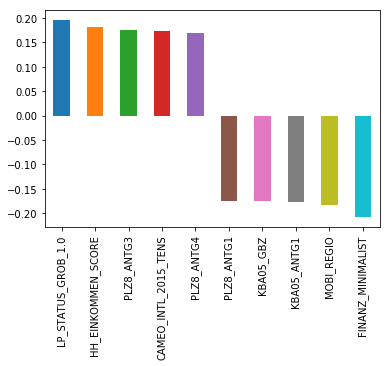

****************************************
LP_STATUS_GROB_1.0  :  0.339408683993
HH_EINKOMMEN_SCORE  :  4.09455288365
PLZ8_ANTG3  :  1.77248409834
CAMEO_INTL_2015_TENS  :  3.2192285026
PLZ8_ANTG4  :  0.755316712598
PLZ8_ANTG1  :  2.17347216589
KBA05_GBZ  :  3.10390520411
KBA05_ANTG1  :  1.49566935771
MOBI_REGIO  :  3.01671047802
FINANZ_MINIMALIST  :  3.40126401421


In [152]:
feature_weights_row = feature_weights.loc[0].sort_values(ascending = False)
feature_weights_row = pd.concat([feature_weights_row.head(5), feature_weights_row.tail(5)])
print(feature_weights_row[:5])
feature_weights_row.plot(kind='bar')
ax = plt.gca()
plt.show()
print('''****************************************''')
for ii in feature_weights_row.index:
    print(ii, ' : ',cluster_specs.loc[0][ii])

In [123]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

For example, it appears that cluster number 14 is underrepresented in customers predictions.
Below we can see the kinds of people that mainly part of this cluster
LP_STATUS_FEIN_3.0     0.203880
LP_STATUS_GROB_4.0     0.199288
KBA05_ANTG4            0.187474
LP_FAMILIE_GROB_3.0    0.181838
LP_STATUS_FEIN_9.0     0.179407
Name: 14, dtype: float64


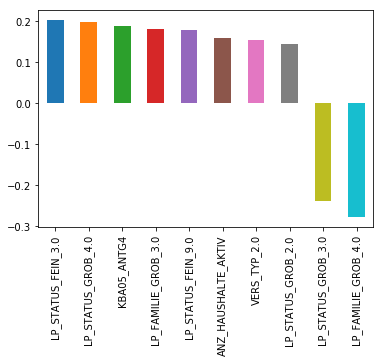

****************************************
LP_STATUS_FEIN_3.0  :  0.0203507638283
LP_STATUS_GROB_4.0  :  0.492480778705
KBA05_ANTG4  :  -0.0758672791723
LP_FAMILIE_GROB_3.0  :  -0.0232289374462
LP_STATUS_FEIN_9.0  :  0.474832513913
ANZ_HAUSHALTE_AKTIV  :  -1.47119761098
VERS_TYP_2.0  :  0.415501687111
LP_STATUS_GROB_2.0  :  0.0687895846738
LP_STATUS_GROB_3.0  :  0.0758128669462
LP_FAMILIE_GROB_4.0  :  0.882862543396


In [154]:
print('For example, it appears that cluster number 14 is underrepresented in customers predictions.')
print('Below we can see the kinds of people that mainly part of this cluster')

feature_weights_row = feature_weights.loc[14].sort_values(ascending = False)
print(feature_weights_row[:5])
feature_weights_row = pd.concat([feature_weights_row.head(8), feature_weights_row.tail(2)])
feature_weights_row.plot(kind='bar')
ax = plt.gca()
plt.show()
print('''****************************************''')
for ii in feature_weights_row.index:
    print(ii, ' : ',cluster_specs.loc[14][ii])

### Discussion 3.3: Compare Customer Data to Demographics Data
As it is presented in the graphs above segments of the population that are relatively popular with the mail-order company are people from cluster and therefore mainly personalities relatively high affinity, investors or in general with tedency for shopping more judging especially from the category SHOPPER_TYP_0.0 (0: external supplied hedonists).

The segments of the populations that the company is relatively unpopular mainly belong to cluster 5. From the LP_STATUS category we can conclude that at some point family people, houseowners etc do not show preference for the mail company.


Looking at the analysis above we see that cluster 0 is overrepresented in customer data compared to the general population. Cluster 0 formed mainly of kinds of people with low to average income but not poor households and with lower to average share of more than 6 households in PLZ8 area.

LP_STATUS_GROB_1.0  :  0.339408683993
HH_EINKOMMEN_SCORE  :  4.09455288365
PLZ8_ANTG3  :  1.77248409834
CAMEO_INTL_2015_TENS  :  3.2192285026
PLZ8_ANTG4  :  0.755316712598

Cluster 14 is underrepresented in customer data compared to the general population. Cluster 14 formed mainly of kinds of people being young single parent or part of a young family with a shared flat with individualistic -accepting risks attitude in trems of insurance topology
LP_STATUS_FEIN_3.0  :  0.0203507638283
LP_STATUS_GROB_4.0  :  0.492480778705
KBA05_ANTG4  :  -0.0758672791723
LP_FAMILIE_GROB_3.0  :  -0.0232289374462
LP_STATUS_FEIN_9.0  :  0.474832513913
ANZ_HAUSHALTE_AKTIV  :  -1.47119761098
VERS_TYP_2.0  :  0.415501687111

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.